In [36]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np

from configs import Hyperion, Prometheus_launch_conditions, current_airbrakes_model
from rocketpy import Environment, Flight, Rocket, SolidMotor
import constants as con

## RocketPy Simulation


### Environment


Define the `Environment` object


In [37]:
# Environment conditions
env = Environment(
    latitude=32.99028,
    longitude=-106.96972,
    date=(2023, 6, 23, 15),
    elevation=1401
)
# may want to add wind

# THE CUSTOM TEMP ISN'T WORKING. It still uses the standard atmosphere model (but it shouldn't make much of a difference (~25 ft apogee change))
def temp_at_altitude(altitude):
    return 307.15 - con.T_lapse_rate * (altitude - 1401)
    # temp at Prometheus launch site was 34C = 307.15 K

env.set_atmospheric_model(
    type="standard_atmosphere", #TBU # update to use our launch conditions and atmospheric model
    temperature = temp_at_altitude
)

Visualize the `Environment` object



Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5534 m/s²


Launch Site Details

Launch Date: 2023-06-23 15:00:00 UTC
Launch Site Latitude: 32.99028°
Launch Site Longitude: -106.96972°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315961.92 W    3651932.28 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1401.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 855.92 hPa
Surface Temperature: 279.06 K
Surface Air Density: 1.068 kg/m³
Surface Speed of Sound: 334.54 m/s


Earth Model Details

Earth Radius at Launch site: 6371.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



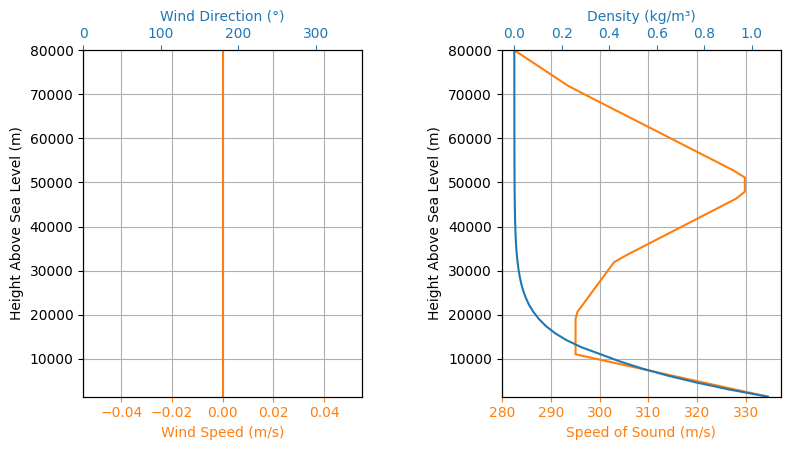

In [38]:
env.info()

### Motor


Define the `SolidMotor` object


In [39]:
thrust_dict = Hyperion.motor.thrust_curve
def thrust_curve(t):
    time_list = list(thrust_dict.keys())
    thrust_list = list(thrust_dict.values())
    if t < time_list[0]:
        return thrust_list[0]
    elif t > time_list[-1]:
        return 0
    else:
        return np.interp(t, time_list, thrust_list)

# rocket: nose_to_tail
motor_M2505 = SolidMotor(
    thrust_source=thrust_curve,
    burn_time=Hyperion.motor.burn_time,
    dry_mass=Hyperion.motor.dry_mass,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=-0.35,#TBU
    grains_center_of_mass_position=-0.35,#TBU

    grain_number=1,#TBU, just picked to give correct mass
    grain_separation=0,#TBU
    grain_density=2150,#TBU, just picked to give correct mass
    grain_outer_radius=0.033,#TBU
    grain_initial_inner_radius=0.015,#TBU
    grain_initial_height=0.57,#TBU, just picked to give correct mass

    nozzle_radius=0.02475,#TBU
    interpolation_method="linear", # the default
    coordinate_system_orientation="combustion_chamber_to_nozzle", #TBU
)

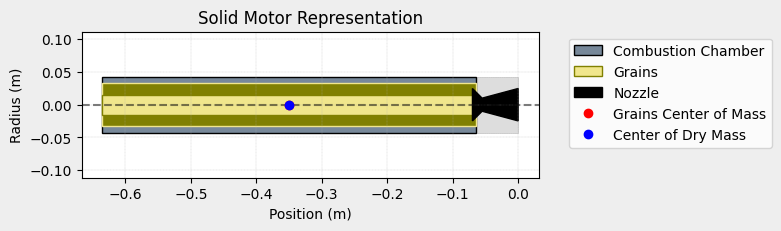

Nozzle Details
Nozzle Radius: 0.02475 m
Nozzle Throat Radius: 0.01 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 2150 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.57 m
Grain Volume: 0.002 m3
Grain Mass: 3.326 kg

Motor Details
Total Burning Time: 3 s
Total Propellant Mass: 3.326 kg
Average Propellant Exhaust Velocity: 2219.217 m/s
Average Thrust: 2460.682 N
Maximum Thrust: 2934.0 N at 1.2244897959183674 s after ignition.
Total Impulse: 7382.046 Ns



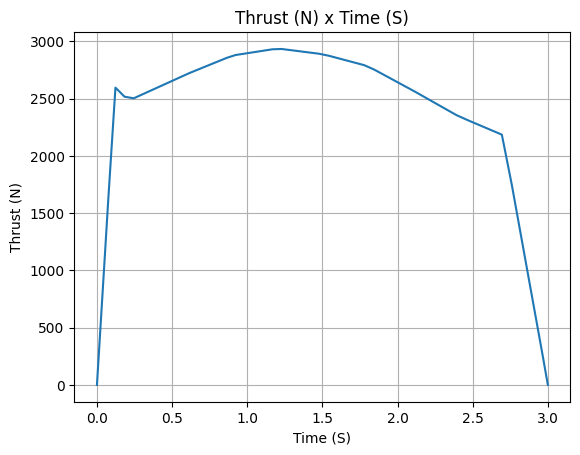

In [40]:
motor_M2505.plots.draw()
motor_M2505.info()

### Rocket


Create the `Rocket` object


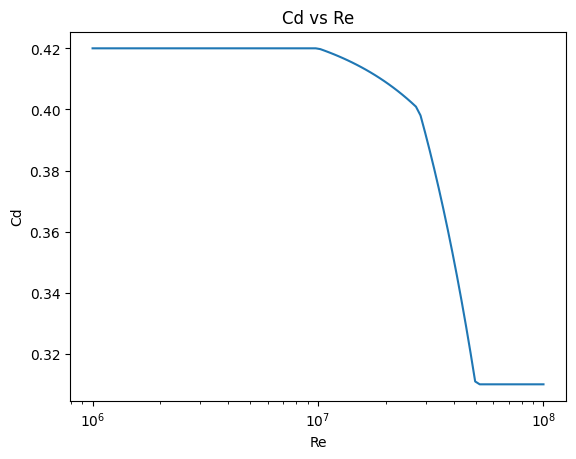

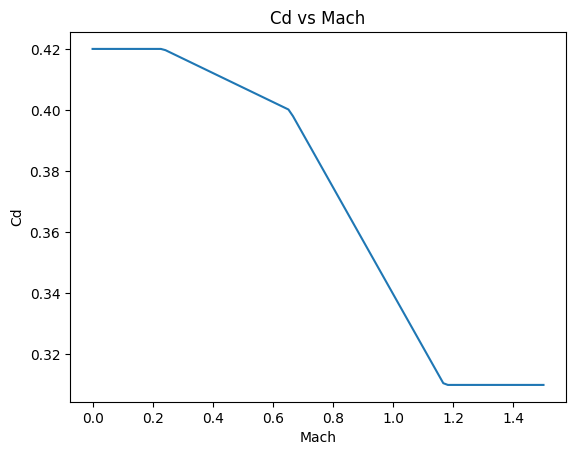

In [41]:
# TBU rough translation of Cd(Re) into a Cd(mach) function
# assumptions:
air_temp_for_mach = 20 + 273.15 # assumed constant at 20C (temp about halfway through flight)
dynamic_viscosity_for_mach = 1.85e-5 # assumed constant at 1.85e-5 (dynamic viscosity at 20C)
air_density_for_mach = 0.85 # assumed constant at 0.85 kg/m^3 (air density about halfway through flight)
# mach = speed / np.sqrt(1.4 * con.R_specific_air * temp)
# Re = air_density * speed * len_characteristic / dynamic_viscosity
# Re = air_density * mach * len_characteristic * np.sqrt(1.4 * con.R_specific_air * temp) / dynamic_viscosity
Cd_at_Re = Hyperion.Cd_rocket_at_Re

# plot CD vs Re
Re = np.logspace(6, 8, 100)
Cds = [Cd_at_Re(re) for re in Re]
plt.plot(Re, Cds)
plt.xscale('log')
plt.xlabel('Re')
plt.ylabel('Cd')
plt.title('Cd vs Re')
plt.show()


def Cd_at_mach(mach):
    Re = air_density_for_mach * mach * Hyperion.L_rocket  * np.sqrt(1.4 * con.R_specific_air * air_temp_for_mach) / dynamic_viscosity_for_mach
    return Cd_at_Re(Re)

# plot CD vs Mach
machs = np.linspace(0, 1.5, 100)
Cds = [Cd_at_mach(mach) for mach in machs]
plt.plot(machs, Cds)
plt.xlabel('Mach')
plt.ylabel('Cd')
plt.title('Cd vs Mach')
plt.show()


Hyperion_RP = Rocket(
    radius = 0.06985, # 5.5" diameter circle
    mass = Hyperion.rocket_mass,
    inertia=(#TBU
        73.316,#TBU
        73.316,#TBU
        0.15982,#TBU
    ),
    power_off_drag=Cd_at_mach,#TBU
    power_on_drag=Cd_at_mach,#TBU
    center_of_mass_without_motor=1.3,#TBU
    coordinate_system_orientation="nose_to_tail",
)

Hyperion_RP.set_rail_buttons(1.5, 2, 45)#TBU

Hyperion_RP.add_motor(motor=motor_M2505, position=3.391)#TBU

Adding aerodynamic surfaces


In [42]:
nose_cone = Hyperion_RP.add_nose(
    length=0.731,
    kind="Von Karman",
    position=0
)

fin_set = Hyperion_RP.add_trapezoidal_fins(
    3,
    span=0.135,
    root_chord=0.331,
    tip_chord=0.1395,
    position=3.05,#TBU
    sweep_angle=13,#TBU
    radius=0.0775, # "transition bottom radius" #TBU
)

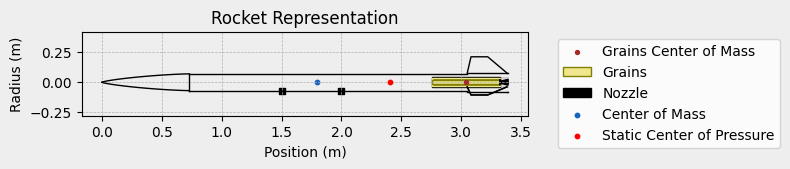

In [43]:
Hyperion_RP.draw()

In [44]:
Hyperion_RP.info()


Inertia Details

Rocket Mass: 15.462 kg (without motor)
Rocket Dry Mass: 18.224 kg (with unloaded motor)
Rocket Loaded Mass: 21.550 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 80.419 kg*m2
Rocket Inertia (with unloaded motor) 22: 80.419 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.160 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.06985 m
Rocket Frontal Area: 0.015328 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.264 m
Rocket Center of Dry Mass - Nozzle Exit: 1.827 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.477 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.228 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.685/rad

Center of Pressure

Nose Cone Center

### Flight - no airbrakes


In [45]:
# Flight - no airbrakes
flight = Flight(
    rocket=Hyperion_RP,
    environment = env,
    rail_length = Prometheus_launch_conditions.L_launch_rail,
    inclination = Prometheus_launch_conditions.launch_angle,
    terminate_on_apogee=True,
)


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1401.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.704 | e1: -0.062 | e2: 0.062 | e3: -0.704
Euler Angles - Spin φ : 0.00° | Nutation θ: -10.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.18  m
Launch Rail Inclination: 80.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.308 s
Rail Departure Velocity: 26.493 m/s
Rail Departure Stability Margin: 4.526 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 12.182
Rail Departure Reynolds Number: 2.269e+05


Burn out State

Burn out time: 3.000 s
Altitude at burn out: 506.860 m (AGL)
Rocket velocity at burn out: 324.223 m/s
Freestream velocity at burn out: 324.223 m/s
Mach Number at burn out: 0.975
Kinetic energy at bur

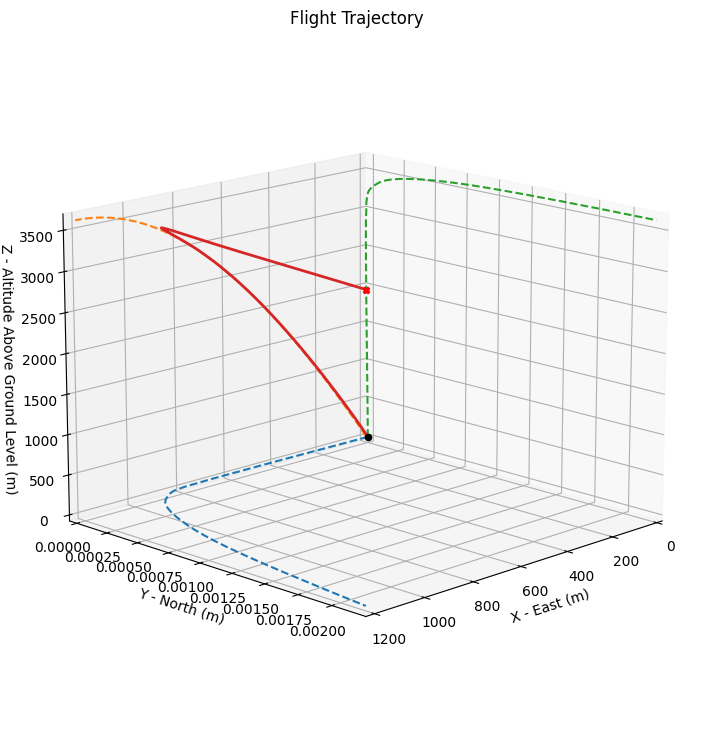

In [46]:
flight.info()
flight.plots.trajectory_3d()

### Flight - with airbrakes

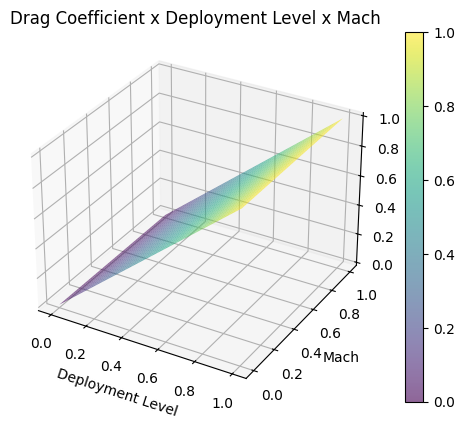

In [47]:
# Define airbrakes
# https://github.com/RocketPy-Team/RocketPy/blob/43b486ab266dca62449e2ad3abe9d427212bc92b/docs/user/airbrakes.rst
portion_deployed_per_sec = current_airbrakes_model.max_deployment_speed/current_airbrakes_model.max_deployment_angle
def controller_function(time, sampling_rate, state, state_history, observed_variables, air_brakes):
    if time < motor_M2505.burn_time[1]:
        return 0
    else:
        old_level = air_brakes.deployment_level
        if old_level == 0: print(f'Beginning airbrake deployment at t={time}')
        new_level = min(old_level + portion_deployed_per_sec/sampling_rate, 1)
        if old_level != new_level:
            if new_level == 1:
                print(f'Airbrakes fully deployed at t={time}')
        # print(old_level, new_level)
        air_brakes.deployment_level = new_level
        return new_level
    # eventually actually implemet a controller, for now just make it go to max deployment to determine stopping power
    # height = state[2]
    # v_y = state[5]


def drag_coefficient_curve(deployment_level, free_stream_mach):
    return current_airbrakes_model.Cd_brakes*deployment_level

airbrakes = Hyperion_RP.add_air_brakes(
    drag_coefficient_curve=drag_coefficient_curve,
    controller_function=controller_function,
    sampling_rate=100,
    clamp=True,
    reference_area=current_airbrakes_model.A_flap*current_airbrakes_model.num_flaps*np.sin(np.deg2rad(current_airbrakes_model.max_deployment_angle)),
    initial_observed_variables=0,
    override_rocket_drag=False
)
airbrakes.all_info()

In [48]:
flight_airbrakes = Flight(
    rocket=Hyperion_RP,
    environment = env,
    rail_length = Prometheus_launch_conditions.L_launch_rail,
    inclination = Prometheus_launch_conditions.launch_angle,
    time_overshoot=False,
    terminate_on_apogee=True
)

Beginning airbrake deployment at t=3.0
Airbrakes fully deployed at t=10.51


In [49]:
print(flight_airbrakes.get_controller_observed_variables())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0013301088270858525, 0.002660217654171705, 0.003990326481257557, 0.00532043530834341, 0.006650544


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1401.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.704 | e1: -0.062 | e2: 0.062 | e3: -0.704
Euler Angles - Spin φ : 0.00° | Nutation θ: -10.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.18  m
Launch Rail Inclination: 80.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.308 s
Rail Departure Velocity: 26.490 m/s
Rail Departure Stability Margin: 4.526 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 12.181
Rail Departure Reynolds Number: 2.268e+05


Burn out State

Burn out time: 3.000 s
Altitude at burn out: 506.861 m (AGL)
Rocket velocity at burn out: 324.227 m/s
Freestream velocity at burn out: 324.227 m/s
Mach Number at burn out: 0.975
Kinetic energy at bur

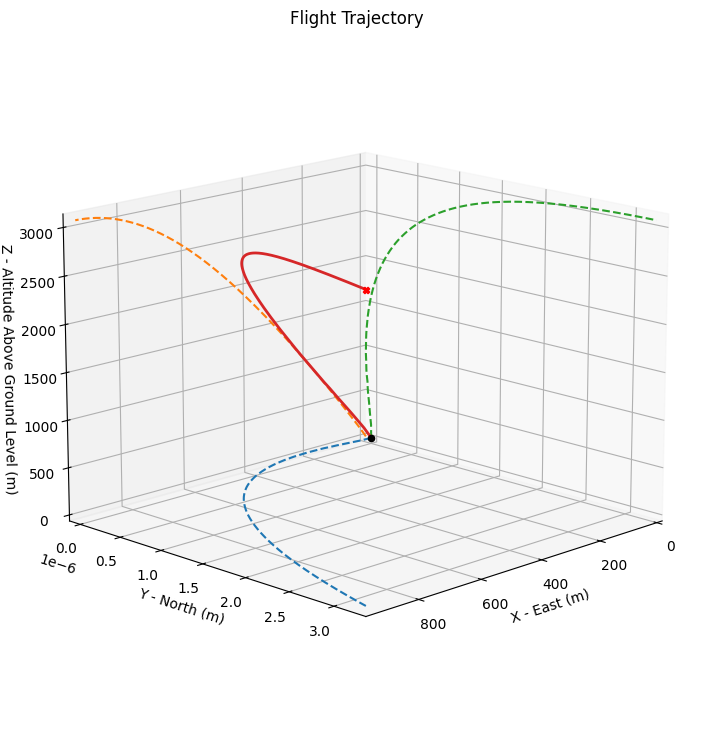

In [50]:
flight_airbrakes.info()
flight_airbrakes.plots.trajectory_3d()